<a href="https://colab.research.google.com/drive/19aCO4g8K5CPGFYOOOaKHXNhtbt--lYVL?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**AUTHOR** : Susnato Dhar (Github : https://github.com/susnato) 



**IMAGE AUGMENTATION**

This Notebook shows how to apply Image Augmentation using JAX, based on 13.1. of http://d2l.ai/chapter_computer-vision/image-augmentation.html



**ACKNOWLEDGEMENTS & MENTIONS**

<ul>
  <li>This Notebook uses <a href="https://github.com/khdlr/augmax">Augmax</a> made by <a href="https://github.com/khdlr">Konrad Heidler</a>. Which is a Image Data Augmentation Framework with support for JAX function transformations.</li>

  <li>Some code of this Notebook greatly resembles from this original <a href="https://github.com/probml/probml-notebooks/blob/main/notebooks-d2l/image_augmentation_torch.ipynb">Notebook</a> which has support for PyTorch.</li>
  
  <li>We only use PyTorch for Data Loading Purposes in other cases we stick to JAX.</li>
</ul>

**Cloning `AUGMAX` Repository & Installing it**

In [1]:
!git clone https://github.com/khdlr/augmax.git -q
!pip install /content/augmax -q

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


**Here are some sample images that I have uploaded to DropBox to use as examples, you can use your own.**

In [2]:
!wget https://www.dropbox.com/s/7pzstlslgbatgvu/cat_dog_sample.zip?dl=0 -q
!unzip -qq /content/cat_dog_sample.zip?dl=0 -d /content/ 

In [3]:
import torch
import torchvision

import cv2
import jax
import augmax
from jax import random as jrand
from jax import numpy as jnp

import matplotlib.pyplot as plt
%matplotlib inline

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

In [4]:
seed = 42
rng = jax.random.PRNGKey(seed)

In [5]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    num_rows = 2 if num_rows<2 else num_rows # no of rows must be greater than equal to 2 in order for the indexing to work in axes
    num_cols = 2 if num_cols<2 else num_cols # no of cols must be greater than equal to 2 in order for the indexing to work in axes
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    count=0
    for i in range(num_rows):# for i 
        for j in range(num_cols):# for j 
          axes[i,j].imshow(imgs[count])
          axes[i,j].axes.get_xaxis().set_visible(True);
          axes[i,j].axes.get_yaxis().set_visible(True);
          if titles:
            axes[i,j].set_title(titles[count])
          count+=1
          if count>=len(imgs):
            break
    plt.tight_layout()

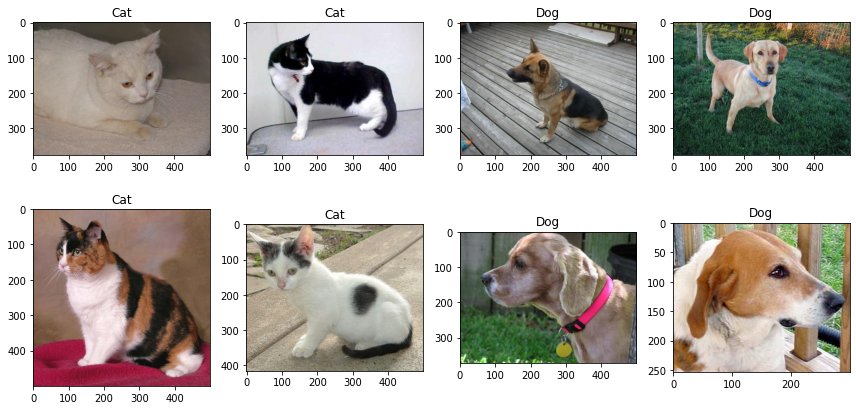

In [6]:
#Let's open all the images we have
img1 = cv2.imread('/content/cat_dog_sample/cat1.jpg')
img2 = cv2.imread('/content/cat_dog_sample/cat2.jpg')
img3 = cv2.imread('/content/cat_dog_sample/dog1.jpg')
img4 = cv2.imread('/content/cat_dog_sample/dog2.jpg')
img5 = cv2.imread('/content/cat_dog_sample/cat3.jpg')
img6 = cv2.imread('/content/cat_dog_sample/cat4.jpg')
img7 = cv2.imread('/content/cat_dog_sample/dog3.jpg')
img8 = cv2.imread('/content/cat_dog_sample/dog4.jpg')

#When we load an image using Open-Cv it's opened in "BGR" format, let's change it to "RGB"

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
img7 = cv2.cvtColor(img7, cv2.COLOR_BGR2RGB)
img8 = cv2.cvtColor(img8, cv2.COLOR_BGR2RGB)

show_images([img1, img2, img3, img4, img5, img6, img7, img8], titles=['Cat', 'Cat', 'Dog', 'Dog','Cat', 'Cat', 'Dog', 'Dog'],num_rows=2,num_cols=4, scale=3)

To visualize an image augmentation, which may be stochastic, we apply it multiple times to an image.

In [7]:
def apply(img, aug, rng, num_rows=2, num_cols=2, scale=3):
    Y = []
    for i in range(num_rows * num_cols):
      transformed_img = aug(rng, img)
      Y.append(transformed_img)
      rng, subkey = jrand.split(rng)
    # Just to make sure that at least 1 image will be augmented if somehow all the 
    # probabilities are not in favour of augmenting the image.
    show_images(Y, num_rows, num_cols, scale=scale) 

# Flipping

In [8]:
h_flip_transform = augmax.HorizontalFlip() #HORIZONTAL FLIP  
v_flip_transform = augmax.VerticalFlip()   #VERTICAL FLIP

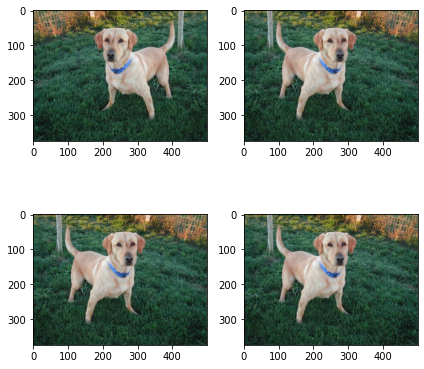

In [9]:
apply(img=img4, aug=h_flip_transform, rng=rng) #HORIZONTAL FLIP

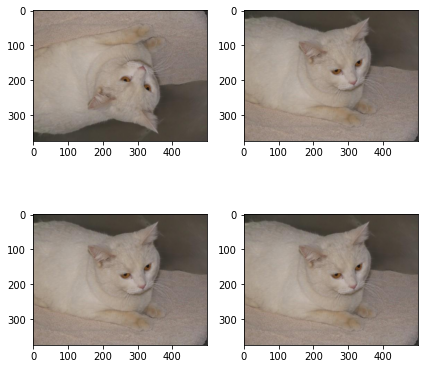

In [10]:
apply(img=img1, aug=v_flip_transform, rng=rng) #VERTICAL FLIP

# Crop and resize

Below, we randomly crop a region with an area of 10% to 100% of the original area, and the ratio of width to height of the region is randomly selected from between 0.5 and 2. Then, the width and height of the region are both scaled to 200 pixels.

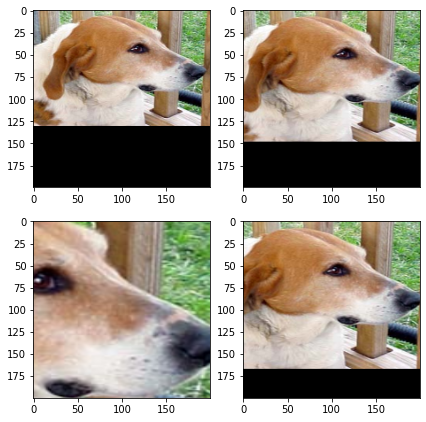

In [11]:
crop_transform = augmax.RandomSizedCrop(int(img1.shape[0]/2), int(img1.shape[1]/2))
resize_transform = augmax.Resize(200, 200)
crop_and_resize_transform = augmax.Chain(crop_transform, resize_transform)

apply(img=img8, aug=crop_and_resize_transform, rng=rng)

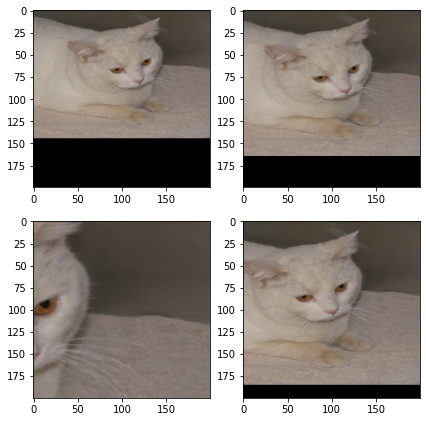

In [12]:
crop_transform = augmax.RandomSizedCrop(
                             int(img1.shape[0]/1.5), int(img1.shape[1]/1.5))
resize_transform = augmax.Resize(200, 200)
crop_and_resize_transform = augmax.Chain(crop_transform, resize_transform)

apply(img=img1, aug=crop_and_resize_transform, rng=rng)

# Changing color

We can change brightness, contrast, saturation and hue. First we change brightness, from 1-0.5=0.5 times less to 1+0.5=1.5 times more.

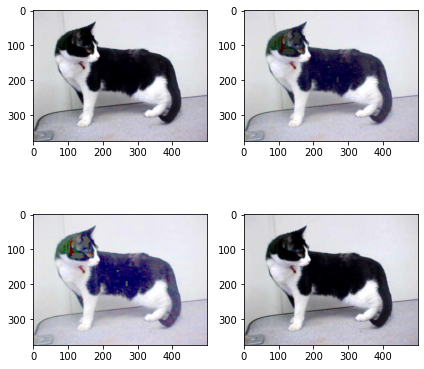

In [13]:
byte2float_transform = augmax.ByteToFloat()
brightness_transform = augmax.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0)

byte2float_brightness_transform = augmax.Chain(byte2float_transform, brightness_transform)

apply(img=img2, aug=byte2float_brightness_transform, rng=rng)



Now we change hue.


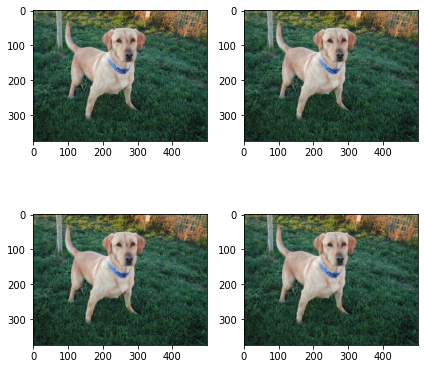

In [14]:
byte2float_transform = augmax.ByteToFloat()
hue_transform = augmax.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5)

byte2float_hue_transform = augmax.Chain(byte2float_transform, hue_transform)

apply(img=img4, aug=byte2float_hue_transform, rng=rng)

Now we change saturation.

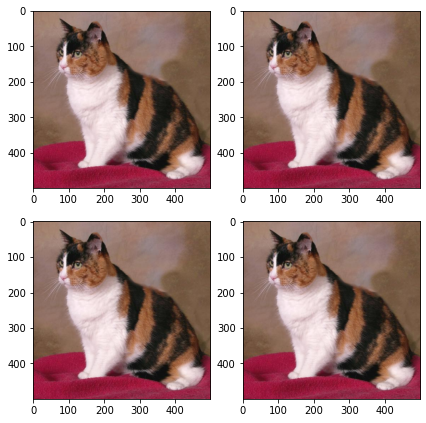

In [15]:
byte2float_transform = augmax.ByteToFloat()
saturation_transform = augmax.ColorJitter(brightness=0, contrast=0, saturation=1, hue=0)

byte2float_saturation_transform = augmax.Chain(byte2float_transform, saturation_transform)

apply(img=img5, aug=byte2float_saturation_transform, rng=rng)



Now we change contrast.


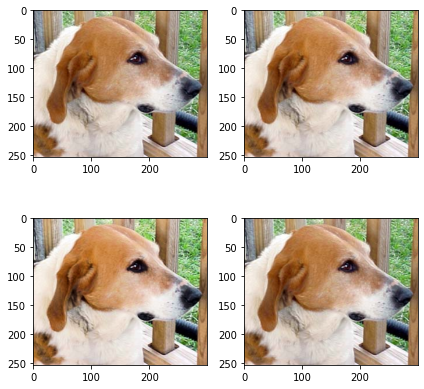

In [16]:
byte2float_transform = augmax.ByteToFloat()
contrast_transform = augmax.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0)

byte2float_contrast_transform = augmax.Chain(byte2float_transform, contrast_transform)

apply(img=img8, aug=byte2float_contrast_transform, rng=rng)

# Combining multiple augmentations in a pipeline

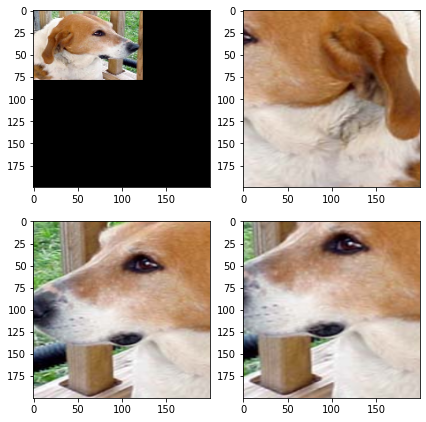

In [17]:
augs1 = augmax.Chain(crop_and_resize_transform, 
                    h_flip_transform, 
                    byte2float_brightness_transform)
apply(img=img8, aug=augs1, rng=rng)

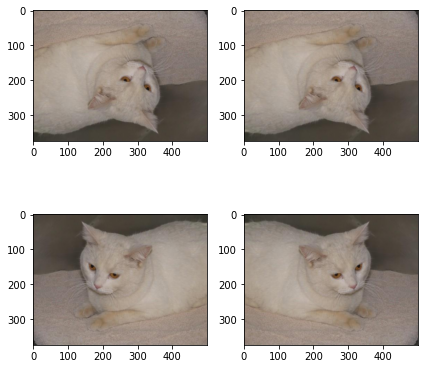

In [18]:
augs2 = augmax.Chain(h_flip_transform,
                    v_flip_transform, 
                    byte2float_hue_transform)
apply(img=img1, aug=augs2, rng=rng)

# Using augmentations in a dataloader

We illustrate how we can transform training and test images from CIFAR10.



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


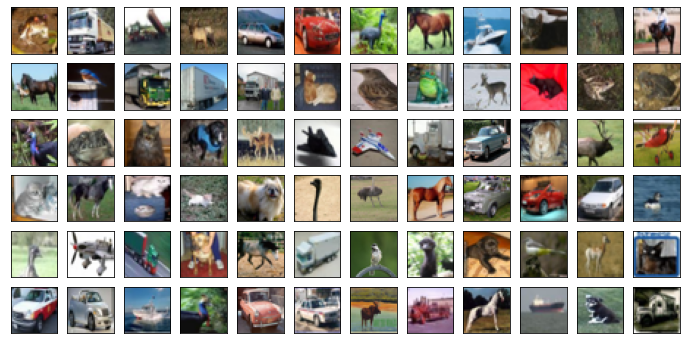

In [19]:
"""
Let's download the CIFAR10 dataset and view some of it's images
"""

all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(72)], 6, 12, scale=1);

In [20]:
"""
Create Augmentation Pipelines in JAX(If you want you can add other augmentations described above,
                                     for now I am only going for the HorizontalFlip)
"""
train_augs = augmax.Chain(
    augmax.HorizontalFlip(),
)
test_augs = augmax.Chain(
    augmax.HorizontalFlip(),
)

In [21]:
"""
We are using PyTorch only for Downloading the DataSet and DataLoader purposes.
"""

def load_cifar10(is_train, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]), 
                                           download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())
    return dataloader

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
<class 'jaxlib.xla_extension.DeviceArray'>
(32, 32, 32, 3)
1
<class 'jaxlib.xla_extension.DeviceArray'>
(32, 32, 32, 3)


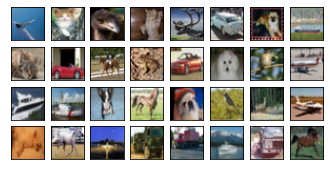

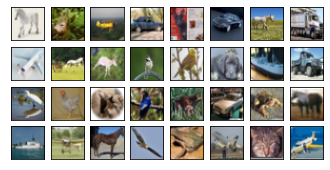

In [22]:
"""
First Load Data using PyTorch DataLoader then convert those batches into JAX Numpy Array.
"""

train_iter = load_cifar10(True, 32)
for i, (features, labels) in enumerate(train_iter):
  print(i)
  features = jnp.array([train_augs(rng, ef.numpy()) for ef in features])
  features = jnp.transpose(features, axes=(0, 2, 3, 1))
  print(type(features))
  print(features.shape)
  d2l.show_images(features, num_rows=4, num_cols=8, scale=0.7)
  if i>=1: 
    break